In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
from tqdm import tqdm
from gensim.models import Word2Vec
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import psutil
import time
import pandas as pd

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

D:\anacevm\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anacevm\pytorch\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\anacevm\pytorch\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable

In [2]:
cpu_count = cpu_count = psutil.cpu_count(logical=False)
if cpu_count > 3:
    cpu_count -= 2
else:
    cpu_count = 1

cpu_count

4

## 读入AnnData数据，var增加一个'gene'列

In [3]:
dataset = 'EB_raw'
obs4color = 'time'
mat_type = 'cosim'

In [4]:
adata = sc.read_h5ad('/EB_raw.h5ad'.format(dataset))
adata

AnnData object with n_obs × n_vars = 16825 × 17580
    obs: 'time'

In [5]:
adata.var['gene'] = adata.var.index

In [6]:
adata.var['gene'] 

A1BG            A1BG
A1BG-AS1    A1BG-AS1
A2M              A2M
A2M-AS1      A2M-AS1
A2ML1          A2ML1
              ...   
ZXDC            ZXDC
ZYG11B        ZYG11B
ZYX              ZYX
ZZEF1          ZZEF1
ZZZ3            ZZZ3
Name: gene, Length: 17580, dtype: object

In [7]:
adata

AnnData object with n_obs × n_vars = 16825 × 17580
    obs: 'time'
    var: 'gene'

In [8]:
n_cell, n_gene = adata.X.shape

In [9]:
adata.X.shape

(16825, 17580)

In [10]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 计算余弦相似度

In [11]:
cosim = cosine_similarity(adata.X.T)

### 对角元取0

In [12]:
for i in range(cosim.shape[0]):
    cosim[i, i] = 0

In [13]:
cosim

array([[0.        , 0.05409953, 0.02737491, ..., 0.10934529, 0.03008012,
        0.05674591],
       [0.05409953, 0.        , 0.005511  , ..., 0.04368326, 0.01362511,
        0.02998759],
       [0.02737491, 0.005511  , 0.        , ..., 0.0328962 , 0.        ,
        0.01669143],
       ...,
       [0.10934529, 0.04368326, 0.0328962 , ..., 0.        , 0.03182511,
        0.06837639],
       [0.03008012, 0.01362511, 0.        , ..., 0.03182511, 0.        ,
        0.01965095],
       [0.05674591, 0.02998759, 0.01669143, ..., 0.06837639, 0.01965095,
        0.        ]], dtype=float32)

## 随机行走（多进程）

In [14]:
def task_allocation(row_num, cpu_count):
    rand_idx = np.array(list(range(row_num)))
    np.random.shuffle(rand_idx)

    per_cpu = int(row_num / cpu_count)
    row_dict = {}
    for i in range(cpu_count - 1):
        idx_list = list(range(i * per_cpu, i * per_cpu + per_cpu))
        row_dict[i] = [rand_idx[idx] for idx in idx_list]

    idx_list = list(range(idx_list[-1] + 1, row_num - 1))
    row_dict[cpu_count - 1] = [rand_idx[idx] for idx in idx_list]

    return row_dict

row_dict = task_allocation(n_gene, cpu_count)

In [15]:
from multiprocessing import shared_memory, Process
import random_walk

rate = 1.0
walk_steps = int(n_gene * rate)

gene_proxim = cosim

cumsum_proxim = np.cumsum(gene_proxim, axis=1)
cumsum_proxim = cumsum_proxim / cumsum_proxim[:, -1].reshape(-1, 1)

gene_corpus = np.zeros((n_gene, walk_steps), dtype=np.int32)

shmr = shared_memory.SharedMemory(create=True, size=cumsum_proxim.nbytes)
np_array = np.ndarray(cumsum_proxim.shape, dtype=cumsum_proxim.dtype, buffer=shmr.buf)
np_array[:] = cumsum_proxim[:]

shmw = shared_memory.SharedMemory(create=True, size=gene_corpus.nbytes)
np_array = np.ndarray(gene_corpus.shape, dtype=gene_corpus.dtype, buffer=shmw.buf)
np_array[:] = gene_corpus[:]

p_list = []
for i in range(cpu_count):
    p_list.append(Process(target=random_walk.random_walk,
                          args=(shmr.name, cumsum_proxim.shape, cumsum_proxim.dtype,
                                shmw.name, gene_corpus.shape, gene_corpus.dtype, walk_steps, row_dict[i])))
    
for p in p_list:
    p.start()
    
for p in p_list:
    p.join()
    
gene_corpus = np.ndarray(gene_corpus.shape, dtype=gene_corpus.dtype, buffer=shmw.buf).copy()

shmr.close()
shmr.unlink()

shmw.close()
shmw.unlink()

In [17]:
gene_corpus

array([[    0,  4503, 11893, ..., 15464, 17544, 12203],
       [    1, 10864,  3043, ...,  1480, 14618,  1578],
       [    2, 10399,    35, ...,  4883,  6576,  4819],
       ...,
       [17577, 16601, 10559, ...,  6850,  1770,  6315],
       [17578, 10780,  2867, ...,  5933,  8677,  4595],
       [17579, 15540, 11139, ...,  6951,  5208,  2411]])

## Word2vec

In [18]:
vector_size = 100
dim = '100'


begin = time.time()
model = Word2Vec(sentences=gene_corpus.tolist(), vector_size=vector_size, min_count=1, workers=cpu_count)
print(time.time() - begin)

457.38907074928284


In [19]:
gene_vec = model.wv.get_normed_vectors()

In [20]:
gene_vec = []

for key in tqdm(model.wv.index_to_key):
    gene_vec.append(model.wv.get_vector(key, norm=False))

gene_vec = np.array(gene_vec)

100%|██████████| 17580/17580 [00:00<00:00, 544453.37it/s]


In [21]:
gene_vec.shape

(17580, 100)

In [22]:
#np.save('/gene_vec_4.npy', gene_vec)

In [34]:
#gene_vec = np.load('/gene_vec_4.npy')

In [23]:
gene_idx_temp = model.wv.key_to_index

In [24]:
gene_idx_temp = model.wv.key_to_index
gene_idx = {}
for key in gene_idx_temp.keys():
    gene = adata.var.index[key]
    idx = gene_idx_temp[key]
    gene_idx[gene] = idx

In [25]:
reducer = umap.UMAP(random_state=42)
gene_embedding = reducer.fit_transform(gene_vec)

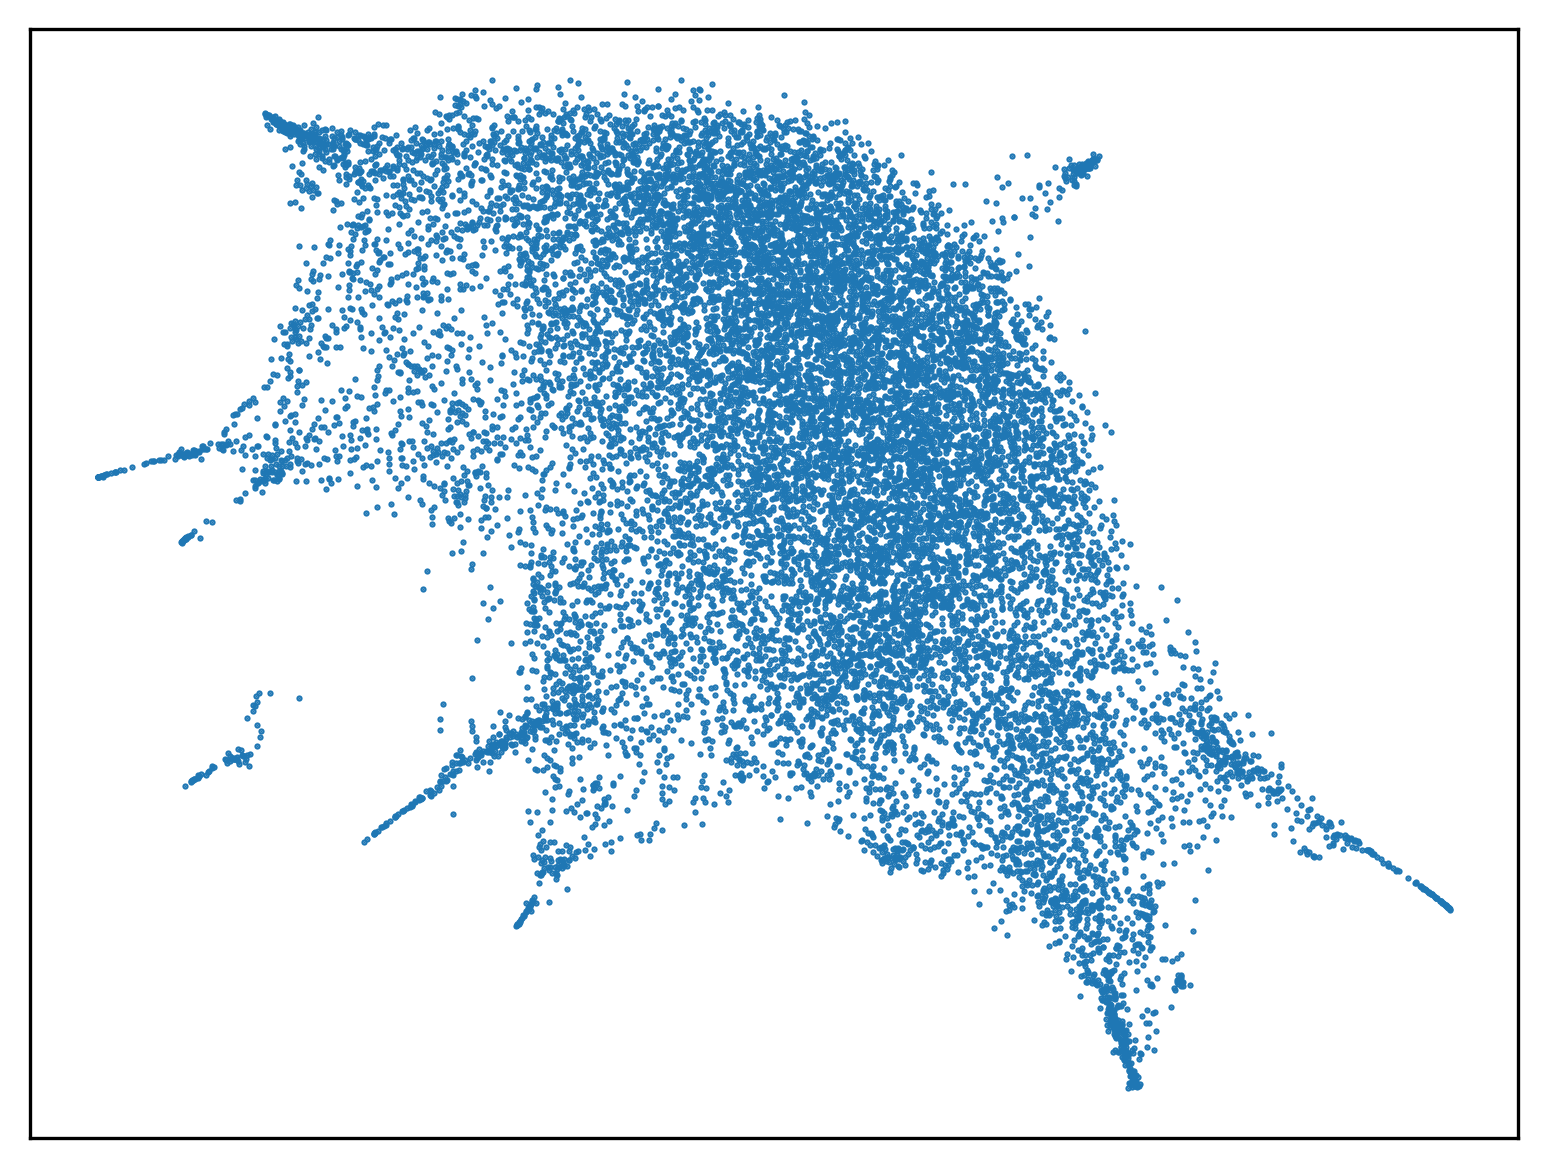

In [26]:
plt.scatter(gene_embedding[:, 0], gene_embedding[:, 1], marker='.', s=1)
plt.xticks([])
plt.yticks([])
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.show()

## 细胞向量

In [27]:
def h5ad2cellvec(ref_gene_idx, ref_gene_vec, h5ad):
    gene_vec = []
    gene_idx = []
    for i in range(len(h5ad.var.index)):
        gene = h5ad.var.index[i]
        if gene in ref_gene_idx.keys():
            ref_idx = ref_gene_idx[gene]
            gene_vec.append(ref_gene_vec[ref_idx])
            gene_idx.append(i)
    gene_vec = np.array(gene_vec)
    
    h5ad = h5ad[:, gene_idx]
    
    cell_vec = []
    for gene_list in tqdm(h5ad.X):
        vec = gene_vec * gene_list.reshape(-1, 1)
        vec = np.sum(vec, axis=0)
        cell_vec.append(vec)
    cell_vec = np.array(cell_vec)
    
    return cell_vec

In [28]:
cell_vec = h5ad2cellvec(gene_idx, gene_vec, adata)

100%|██████████| 16825/16825 [01:21<00:00, 205.67it/s]


In [29]:
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm)

In [30]:
cell_norm_vec = h5ad2cellvec(gene_idx, gene_vec, adata_norm)

100%|██████████| 16825/16825 [01:21<00:00, 206.71it/s]


In [31]:
reducer = umap.UMAP(random_state=42)
cell_norm_embedding = reducer.fit_transform(cell_norm_vec)

In [33]:
color_list_520 = np.load('/rainbow_color_520.npy')

def get_category_color(category_list, color_list):
    dn = len(color_list) // len(category_list)
    color_list = [tuple(color_list[i*dn]) for i in range(len(category_list))]
    
    return dict(zip(category_list, color_list))

category_list = list(adata.obs[obs4color].unique())
cate_color = get_category_color(category_list, color_list_520)
cell_color = [cate_color[cate] for cate in adata.obs[obs4color]]

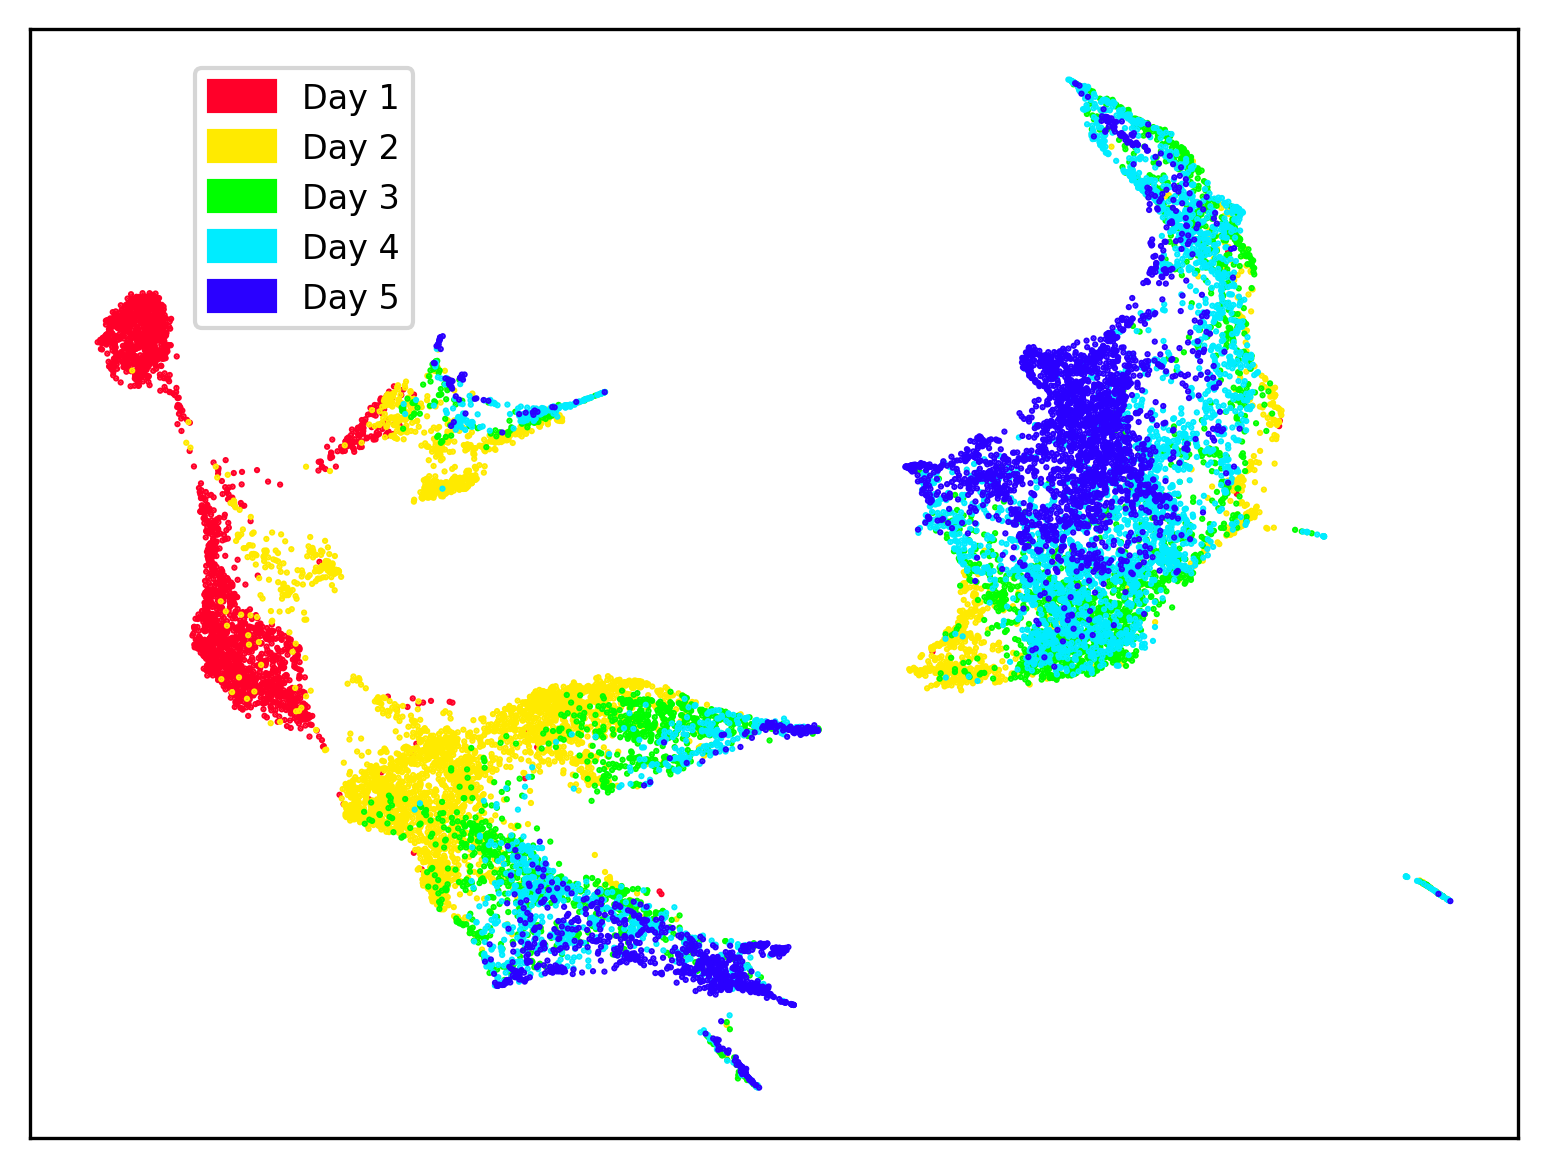

In [38]:
plt.scatter(cell_norm_embedding[:, 0], cell_norm_embedding[:, 1], marker='.', c=cell_color, s=1)

plt.xticks([])
plt.yticks([])
plt.tick_params(bottom=False, top=False, left=False, right=False)

ax=plt.gca()
box = ax.get_position()
patches = [mpatches.Patch(color=cate_color[cate], label=cate) for cate in cate_color.keys()] 

#下面一行中bbox_to_anchor指定了legend的位置
ax.legend(handles=patches, ncol=1, handleheight=1, bbox_to_anchor=(0.1, 0.98), fontsize=8)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

In [39]:
import numpy as np
color_list_520 = np.load('/rainbow_color_520.npy')
color_list_520

array([[1.        , 0.        , 0.16      ],
       [1.        , 0.        , 0.16      ],
       [1.        , 0.        , 0.13908497],
       ...,
       [1.        , 0.        , 0.77131287],
       [1.        , 0.        , 0.75      ],
       [1.        , 0.        , 0.75      ]])

In [40]:
import scanpy as sc
import numpy as np
from scipy.sparse import issparse
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
from anndata import AnnData
from typing import Optional, Union
from matplotlib.axes import Axes

In [41]:
##L2 norm
def l2_norm(x, axis=-1):
    if issparse(x):
        return np.sqrt(x.multiply(x).sum(axis=axis).A1)
    else:
        return np.sqrt(np.sum(x * x, axis = axis))

def cosine_similarity(
    adata: AnnData,
    zs_key: str,
    reverse: bool = False,
    use_rep_neigh: Optional[str] = None,
    vf_key: str = 'VF',
    run_neigh: bool = True,
    n_neigh: int = 20,
    t_key: Optional[str] = None,
    var_stabilize_transform: bool = False,
) -> csr_matrix:
    """
    Calculate the cosine similarity between the vector field and the cell-neighbor latent state difference for each cell.
    The calculation borrows the ideas from scvelo: https://github.com/theislab/scvelo/blob/master/scvelo/tools/velocity_graph.py.
    Parameters
    ----------
    adata
        An :class:`~anndata.AnnData` object.
    reverse
        Whether to reverse the direction of vector field.
        (Default: `False`)
    zs_key
        The key in `.obsm` for storing the latent space.
    vf_key
        The key in `.obsm` for storing the vector field.
        (Default: `'VF'`)
    run_neigh
        Whether to run neighbor detection.
        (Default: `True`)
    use_rep_neigh
        The representation in `.obsm` for neighbor detection.
    n_neigh
        The number of neighbors for each cell.
        (Default: 20)
    t_key:
        The key in `.obs` for estimated time for neighbor detection.
    var_stabilize_transform
        Whether to perform variance-stabilizing transformation for vector field and cell-neighbor latent state difference.
        (Default: `False`)
    Returns
    ----------
    :class:`~scipy.sparse.csr_matrix`
        A sparse matrix with cosine similarities.
    """

    Z = adata.obsm[f'X_{zs_key}']
    V = adata.obsm[f'X_{vf_key}']
    if reverse:
        V = -V
    if var_stabilize_transform:
        V = np.sqrt(np.abs(V)) * np.sign(V)

    ncells = adata.n_obs

    if run_neigh:
        sc.pp.neighbors(adata, use_rep = f'X_{use_rep_neigh}', n_neighbors = n_neigh)
    n_neigh = adata.uns['neighbors']['params']['n_neighbors'] - 1
    indices_matrix = adata.obsp['distances'].indices.reshape(-1, n_neigh)

    if t_key is not None:
        ts = adata.obs[t_key].values
        indices_matrix2 = np.zeros(indices_matrix.shape, dtype = int)
        for i in range(ncells):
            idx = np.abs(ts - ts[i]).argsort()[:(n_neigh + 1)]
            idx = np.setdiff1d(idx, i) if i in idx else idx[:-1]
            indices_matrix2[i] = idx
        indices_matrix = np.hstack([indices_matrix, indices_matrix2])

    vals, rows, cols = [], [], []
    for i in range(ncells):
        idx = np.unique(indices_matrix[i])
        idx2 = indices_matrix[idx].flatten()
        idx2 = np.setdiff1d(idx2, i)
        idx = np.unique(np.concatenate([idx, idx2]))
        dZ = Z[idx] - Z[i, None]
        if var_stabilize_transform:
            dZ = np.sqrt(np.abs(dZ)) * np.sign(dZ)
        cos_sim = np.einsum("ij, j", dZ, V[i]) / (l2_norm(dZ, axis = 1) * l2_norm(V[i]))
        vals.extend(cos_sim)
        rows.extend(np.repeat(i, len(idx)))
        cols.extend(idx)

    res = coo_matrix((vals, (rows, cols)), shape = (ncells, ncells))
    res.data = np.clip(res.data, -1, 1)
    return res.tocsr()


def quiver_autoscale(
    E: np.ndarray,
    V: np.ndarray,
):
    """
    Get the autoscaling in quiver.
    This function is from scvelo: https://github.com/theislab/scvelo/blob/master/scvelo/tools/velocity_embedding.py.
    Parameters
    ----------
    E
        The embedding.
    V
        The weighted unitary displacement.
    Returns
    ----------
    The autoscaling factor.
    """

    fig, ax = plt.subplots()
    scale_factor = np.abs(E).max()

    Q = ax.quiver(
        E[:, 0] / scale_factor,
        E[:, 1] / scale_factor,
        V[:, 0],
        V[:, 1],
        angles = 'xy',
        scale = None,
        scale_units = 'xy',
    )
    Q._init()
    fig.clf()
    plt.close(fig)
    return Q.scale / scale_factor


def vector_field_embedding(
    adata: AnnData,
    T_key: str,
    E_key: str,
    scale: int = 10,
    self_transition: bool = False,
):
    """
    Calculate the weighted unitary displacement vectors under a certain embedding.
    This function borrows the ideas from scvelo: https://github.com/theislab/scvelo/blob/master/scvelo/tools/velocity_embedding.py.
    Parameters
    ----------
    adata
        An :class:`~anndata.AnnData` object.
    T_key
        The key in `.obsp` for cosine similarity.
    E_key
        The key in `.obsm` for embedding.
    scale
        Scale factor for cosine similarity.
        (Default: 10)
    self_transition
        Whether to take self-transition into consideration.
        (Default: `False`)
    Returns
    ----------
    The weighted unitary displacement vectors.
    """

    T = adata.obsp[T_key]

    if self_transition:
        max_t = T.max(1).A.flatten()
        ub = np.percentile(max_t, 98)
        self_t = np.clip(ub - max_t, 0, 1)
        T.setdiag(self_t)

    T = T.sign().multiply(np.expm1(abs(T * scale)))
    T = T.multiply(csr_matrix(1.0 / abs(T).sum(1)))
    if self_transition:
        T.setdiag(0)
        T.eliminate_zeros()

    E = adata.obsm[f'X_{E_key}']
    V = np.zeros(E.shape)

    for i in range(adata.n_obs):
        idx = T[i].indices
        dE = E[idx] - E[i, None]
        dE /= l2_norm(dE)[:, None]
        dE[np.isnan(dE)] = 0
        prob = T[i].data
        V[i] = prob.dot(dE) - prob.mean() * dE.sum(0)

#     V /= 3 * quiver_autoscale(E, V)
    return V


def vector_field_embedding_grid(
    E: np.ndarray,
    V: np.ndarray,
    smooth: float = 0.5,
    stream: bool = False,
) -> tuple:
    """
    Estimate the unitary displacement vectors within a grid.
    This function borrows the ideas from scvelo: https://github.com/theislab/scvelo/blob/master/scvelo/plotting/velocity_embedding_grid.py.
    Parameters
    ----------
    E
        The embedding.
    V
        The unitary displacement vectors under the embedding.
    smooth
        The factor for scale in Gaussian kernel.
        (Default: 0.5)
    stream
        Whether to adjust for streamplot.
        (Default: `False`)
    Returns
    ----------
    tuple
        The embedding and unitary displacement vectors in grid level.
    """

    grs = []
    for i in range(E.shape[1]):
        m, M = np.min(E[:, i]), np.max(E[:, i])
        diff = M - m
        m = m - 0.01 * diff
        M = M + 0.01 * diff
        gr = np.linspace(m, M, 50)
        grs.append(gr)

    meshes = np.meshgrid(*grs)
    E_grid = np.vstack([i.flat for i in meshes]).T

    n_neigh = int(E.shape[0] / 50)
    nn = NearestNeighbors(n_neighbors = n_neigh, n_jobs = -1)
    nn.fit(E)
    dists, neighs = nn.kneighbors(E_grid)

    scale = np.mean([g[1] - g[0] for g in grs]) * smooth
    weight = norm.pdf(x = dists, scale = scale)
    weight_sum = weight.sum(1)

    V_grid = (V[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, weight_sum)[:, None]

    if stream:
        E_grid = np.stack(grs)
        V_grid = V_grid.T.reshape(2, 50, 50)

        mass = np.sqrt((V_grid * V_grid).sum(0))
        min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.percentile(mass, 99) * 0.01)
        cutoff1 = (mass < min_mass)

        length = np.sum(np.mean(np.abs(V[neighs]), axis = 1), axis = 1).reshape(50, 50)
        cutoff2 = (length < np.percentile(length, 5))

        cutoff = (cutoff1 | cutoff2)
        V_grid[0][cutoff] = np.nan
    else:
        min_weight = np.percentile(weight_sum, 99) * 0.01
        E_grid, V_grid = E_grid[weight_sum > min_weight], V_grid[weight_sum > min_weight]
        V_grid /= 3 * quiver_autoscale(E_grid, V_grid)

    return E_grid, V_grid


def plot_vector_field(
    adata: AnnData,
    reverse: bool = False,
    zs_key: Optional[str] = None,
    vf_key: str = 'VF',
    run_neigh: bool = True,
    use_rep_neigh: Optional[str] = None,
    t_key: Optional[str] = None,
    n_neigh: int = 20,
    var_stabilize_transform: bool = False,
    E_key: str = 'umap',
    scale: int = 10,
    self_transition: bool = False,
    smooth: float = 0.5,
    grid: bool = False,
    stream: bool = True,
    stream_density: int = 2,
    stream_color: str = 'k',
    linewidth: int = 1,
    arrowsize: int = 1,
    density: float = 1.,
    arrow_size_grid: int = 5,
    color: Optional[str] = None,
    ax: Optional[Axes] = None,
    **kwargs,
):
    """
    Visualize the vector field.
    The visulization of vector field under an embedding borrows the ideas from scvelo: https://github.com/theislab/scvelo.
    Parameters
    ----------
    adata
        An :class:`~anndata.AnnData` object.
    reverse
        Whether to reverse the direction of vector field.
    zs_key
        The key in `.obsm` for storing the latent space.
    vf_key
        The key in `.obsm` for storing the vector field.
    run_neigh
        Whether to run neighbor detection.
    use_rep_neigh
        The representation in `.obsm` for neighbor detection.
    t_key:
        The key in `.obs` for estimated time for neighbor detection.
    n_neigh
        The number of neighbors for each cell.
    var_stabilize_transform
        Whether to perform variance-stabilizing transformation for vector field and cell-neighbor latent state difference.
    E_key
        The key in `.obsm` for embedding.
    scale
        Scale factor for cosine similarity.
    self_transition
        Whether to take self-transition into consideration.
    smooth
        The factor for scale in Gaussian kernel.
    grid
        Whether to draw grid-level vector field.
    stream
        Whether to draw streamplot.
    stream_density
        The density parameter for streamplot for controlling the closeness of the streamlines.
    stream_color
        The streamline color for streamplot.
    linewidth
        The line width for streamplot.
    arrowsize
        The arrow size for streamplot.
    density
        Percentage of cell positions to show.
    arrow_size_grid
        The arrow size in grid-level vector field.
    color
        `color` parameter in :func:`scanpy.pl.umap`.
    ax
        The matplotlib axes
    kwargs
        Parameters passed to :func:`scanpy.pl.umap`
    Returns
    ----------
    :class:`~matplotlib.axes.Axes`
        An :class:`~matplotlib.axes.Axes` object.
    """

    ##calculate cosine similarity
    adata.obsp['cosine_similarity'] = cosine_similarity(
                                        adata,
                                        reverse = reverse,
                                        zs_key = zs_key,
                                        vf_key = vf_key,
                                        run_neigh = run_neigh,
                                        use_rep_neigh = use_rep_neigh,
                                        t_key = t_key,
                                        n_neigh = n_neigh,
                                        var_stabilize_transform = var_stabilize_transform,
                                        )
    ##get weighted unitary displacement vectors under a certain embedding
    adata.obsm['X_DV'] = vector_field_embedding(
                            adata,
                            T_key = 'cosine_similarity',
                            E_key = E_key,
                            scale = scale,
                            self_transition = self_transition,
                        )

    E = adata.obsm[f'X_{E_key}']
    V = adata.obsm[f'X_DV']

    if grid:
        stream = False

    if grid or stream:
        E, V = vector_field_embedding_grid(
                E = E,
                V = V,
                smooth = smooth,
                stream = stream,
                )

    if stream:
        lengths = np.sqrt((V * V).sum(0))
        linewidth *= 2 * lengths / lengths[~np.isnan(lengths)].max()
        stream_kwargs = dict(
            linewidth = linewidth,
            density = stream_density,
            zorder = 3,
            color = stream_color,
            arrowsize = arrowsize,
            arrowstyle = '-|>',
            maxlength = 4,
            integration_direction = 'both',
        )
        ax.streamplot(E[0], E[1], V[0], V[1], **stream_kwargs)
    else:
        if density < 1:
            idx = np.random.choice(len(E), int(len(E) * density), replace = False)
            E = E[idx]
            V = V[idx]
        quiver_kwargs = dict(
            angles = 'xy',
            scale_units = 'xy',
            edgecolors = 'k',
            scale = 1 / arrow_size_grid,
            width = 0.001,
            headlength = 12,
            headwidth = 10,
            headaxislength = 8,
            color = 'grey',
            linewidth = 1,
            zorder = 3,
        )
        ax.quiver(E[:, 0], E[:, 1], V[:, 0], V[:, 1], **quiver_kwargs)

    ax = sc.pl.embedding(adata, basis = E_key, color = color, ax = ax, show=False, **kwargs)

    return ax

In [42]:
adata.obsm['X_umap'] = cell_norm_embedding

In [43]:
adata.obsm['X_cellvec'] = cell_norm_vec

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(cell_color, name='custom_map2')
plt.register_cmap(cmap=cmap)


C:\Users\79143\AppData\Local\Temp\ipykernel_11140\2253523462.py:4: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=cmap)


In [45]:
gene_index = adata.var.index.get_loc('POU5F1')
gene_index


10748

In [46]:
gene_index = adata.var.index.get_loc('OTX2')
gene_index

9887

In [57]:
velocity=np.tile(2*gene_vec[9887]-0.5*gene_vec[10748],(n_cell,1))
adata.obsm['X_velocity'] = velocity

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


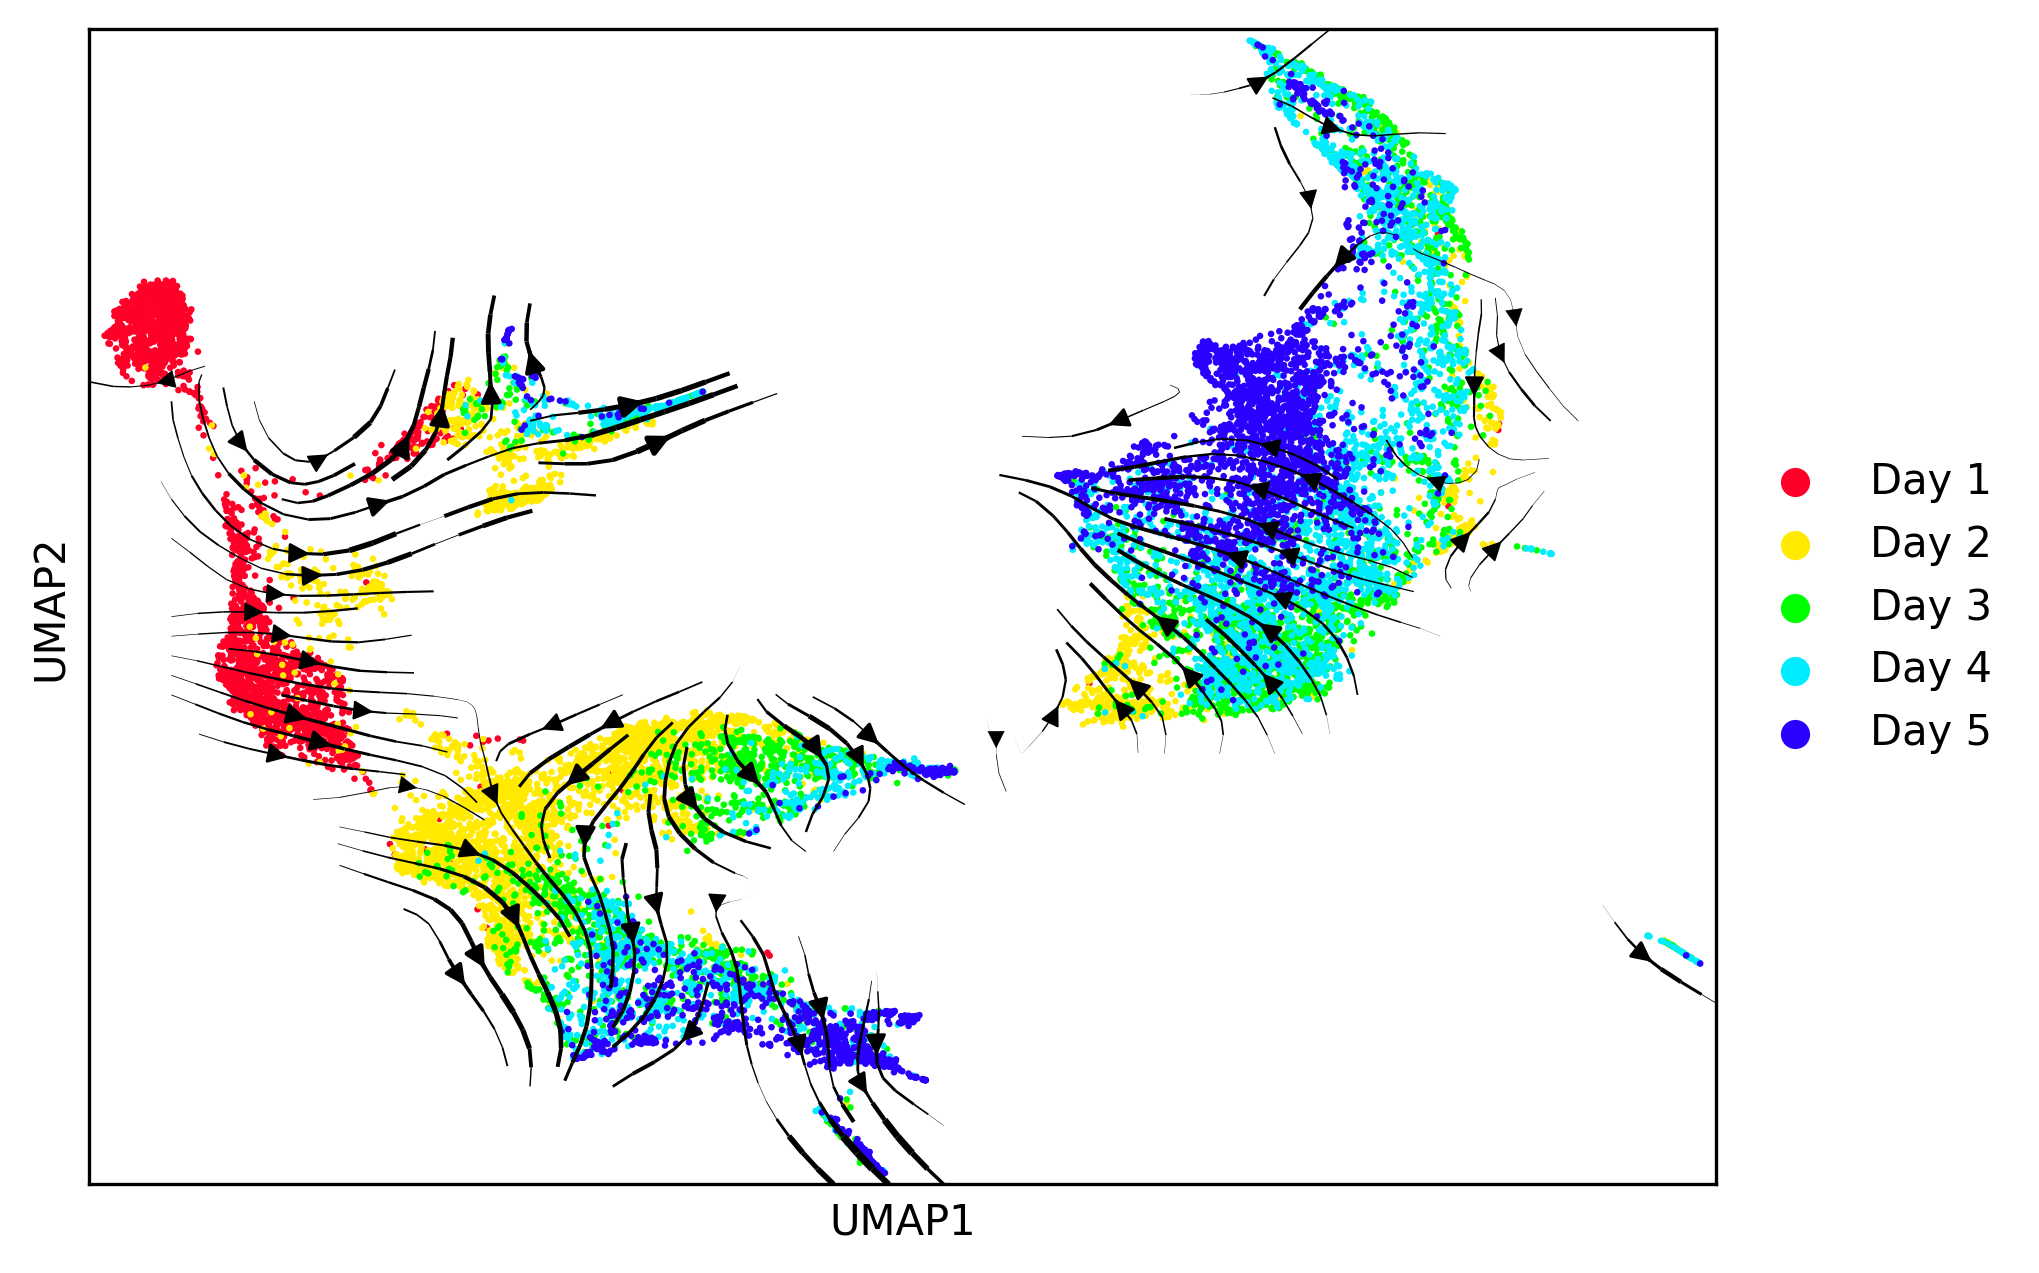

In [58]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
ax = plot_vector_field(adata, E_key='umap', zs_key='cellvec', vf_key='velocity', use_rep_neigh='cellvec',
                  ax=axs, color='time', size=10, palette='custom_map2', grid=False, density=0.8)
ax.set_title(None)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

In [63]:
velocity=np.tile(2*gene_vec[5621]+2*gene_vec[13430]+2*gene_vec[7358]-0.2*gene_vec[4641]-0.2*gene_vec[5403],(n_cell,1))
adata.obsm['X_velocity'] = velocity

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


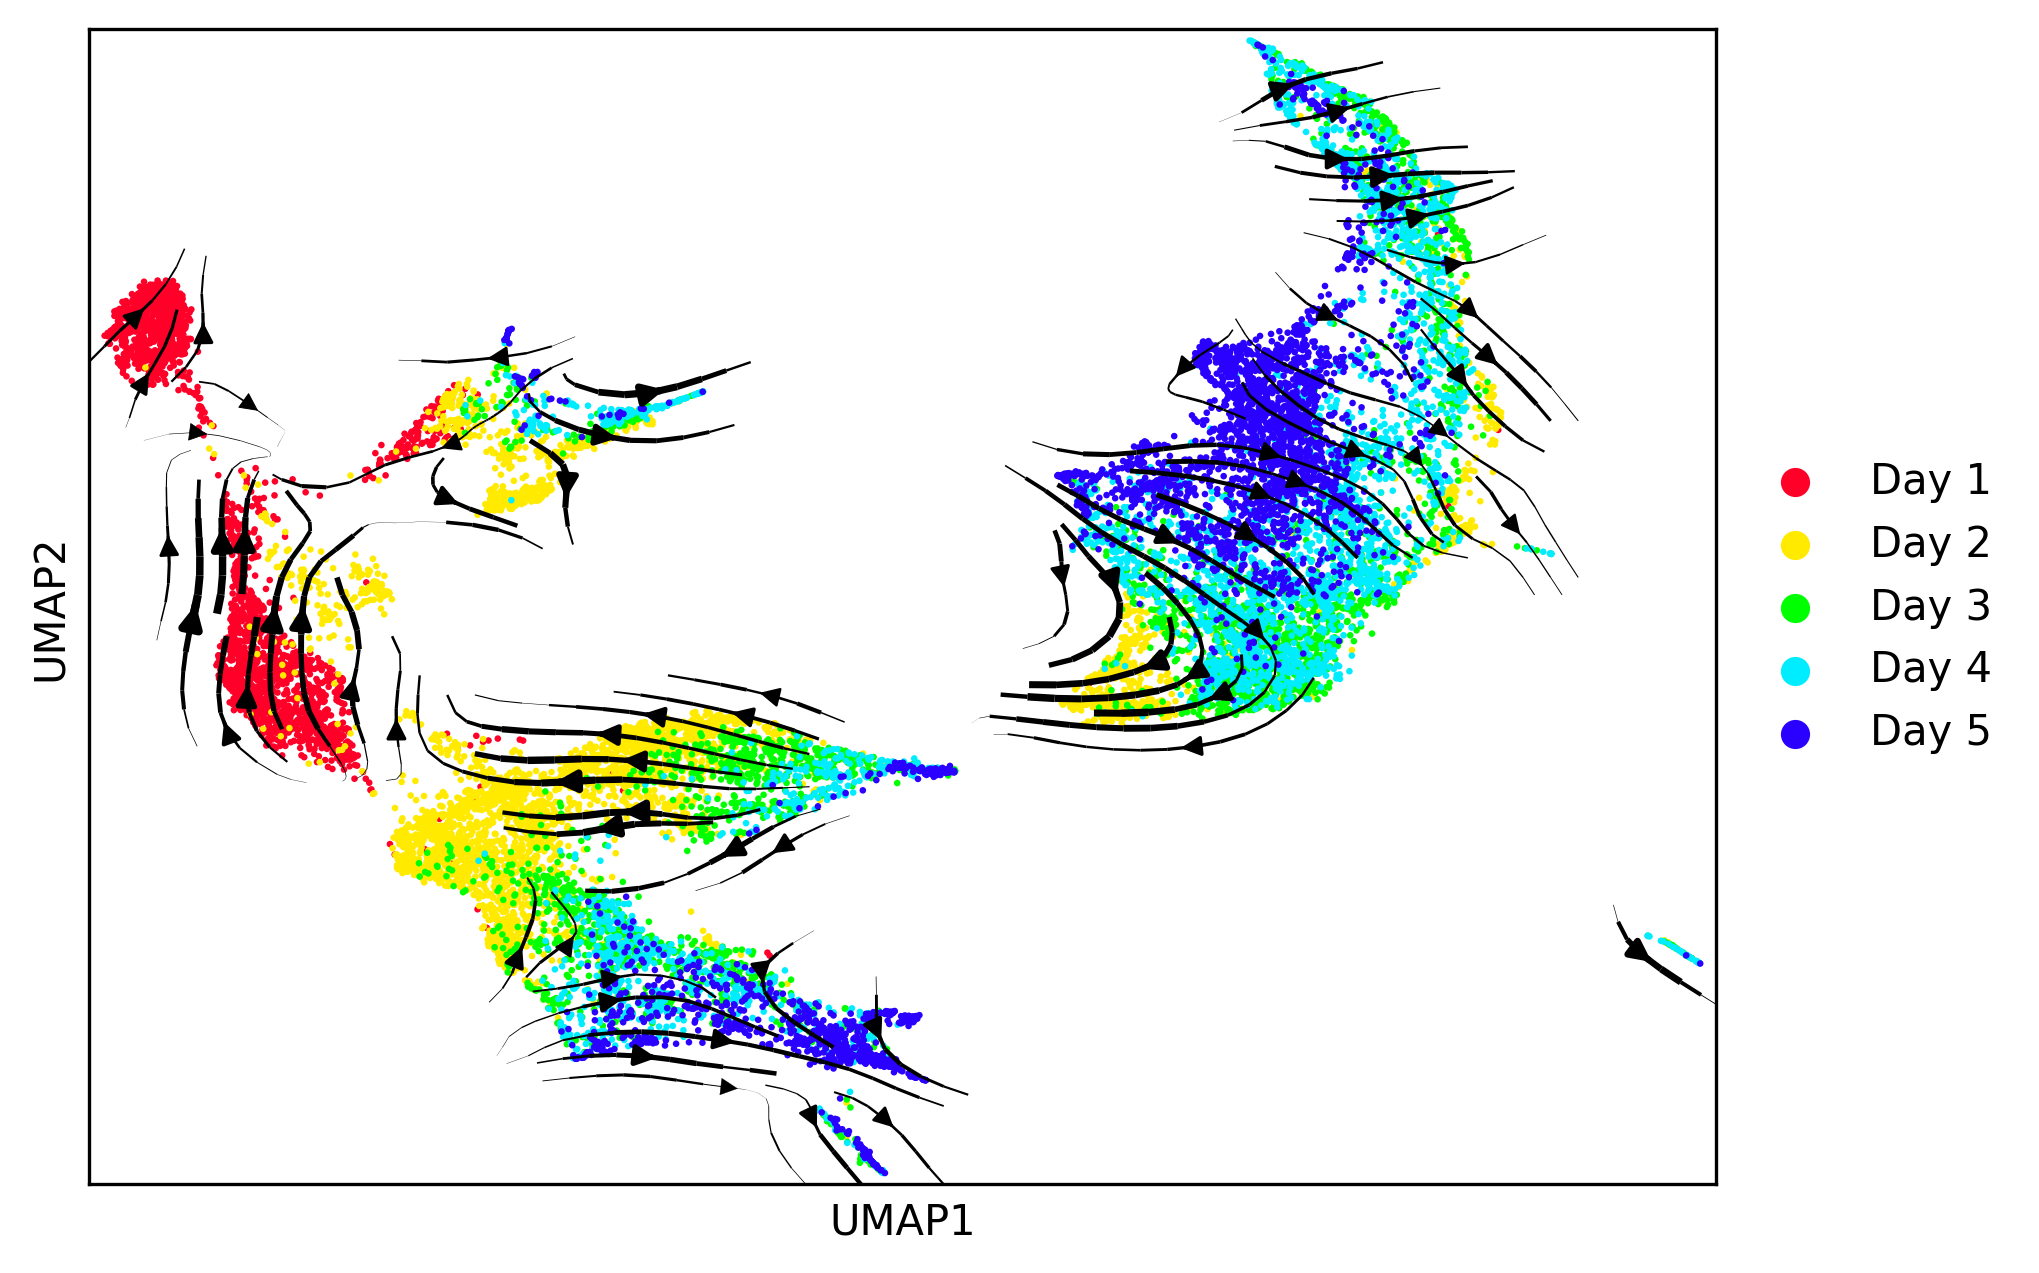

In [64]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
ax = plot_vector_field(adata, E_key='umap', zs_key='cellvec', vf_key='velocity', use_rep_neigh='cellvec',
                  ax=axs, color='time', size=10, palette='custom_map2', grid=False, density=0.8)
ax.set_title(None)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

In [65]:
#POU5F1
velocity=np.tile(-0.5*gene_vec[10748],(n_cell,1))
adata.obsm['X_velocity'] = velocity

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


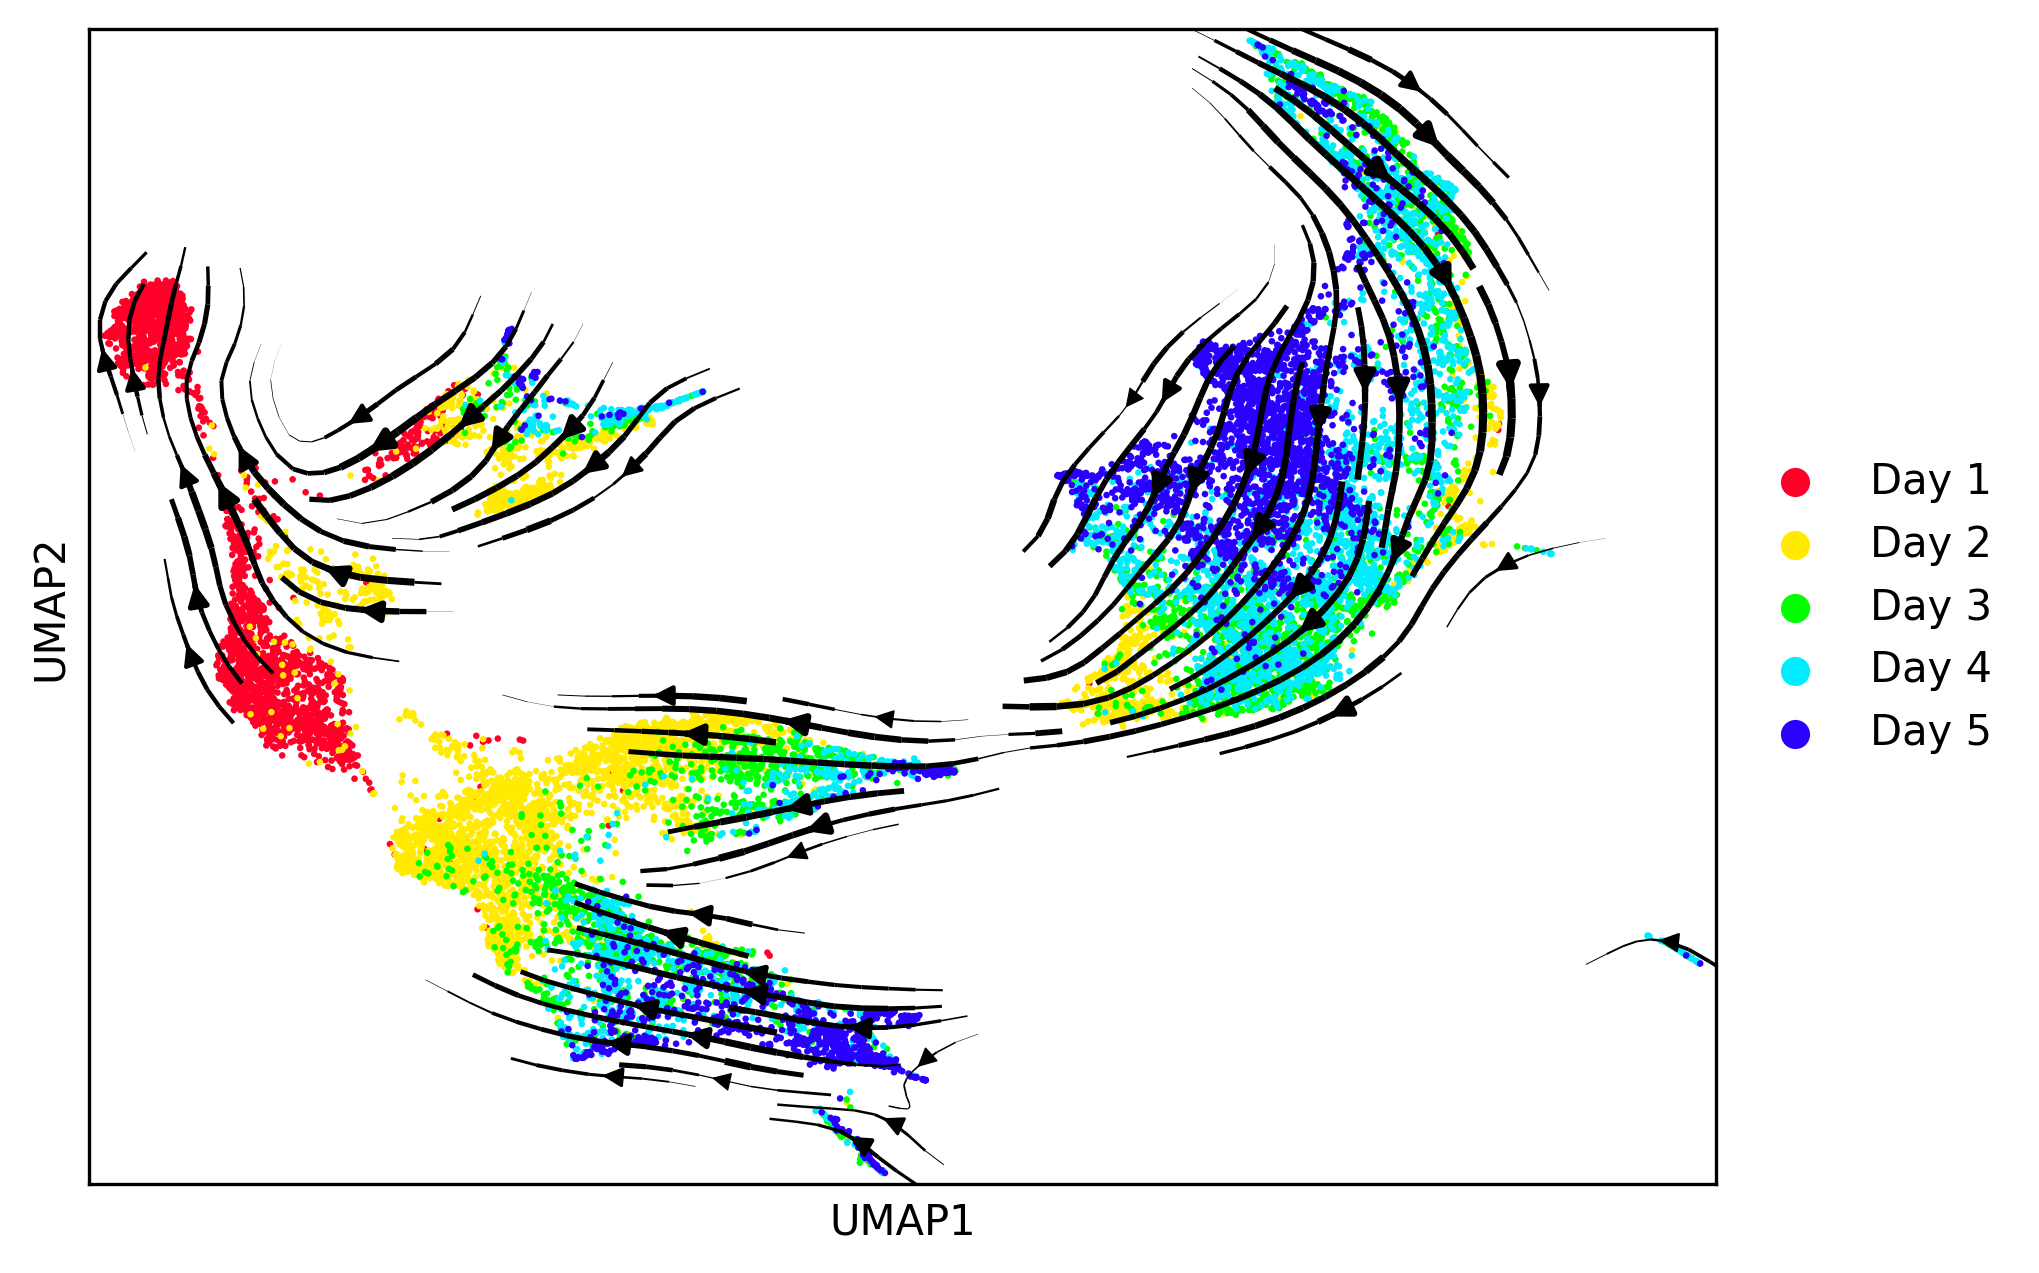

In [66]:

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
ax = plot_vector_field(adata, E_key='umap', zs_key='cellvec', vf_key='velocity', use_rep_neigh='cellvec',
                  ax=axs, color='time', size=10, palette='custom_map2', grid=False, density=0.8)
ax.set_title(None)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

In [54]:
velocity=np.tile(2*gene_vec[9887],(n_cell,1))#'OTX2'
adata.obsm['X_velocity'] = velocity

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


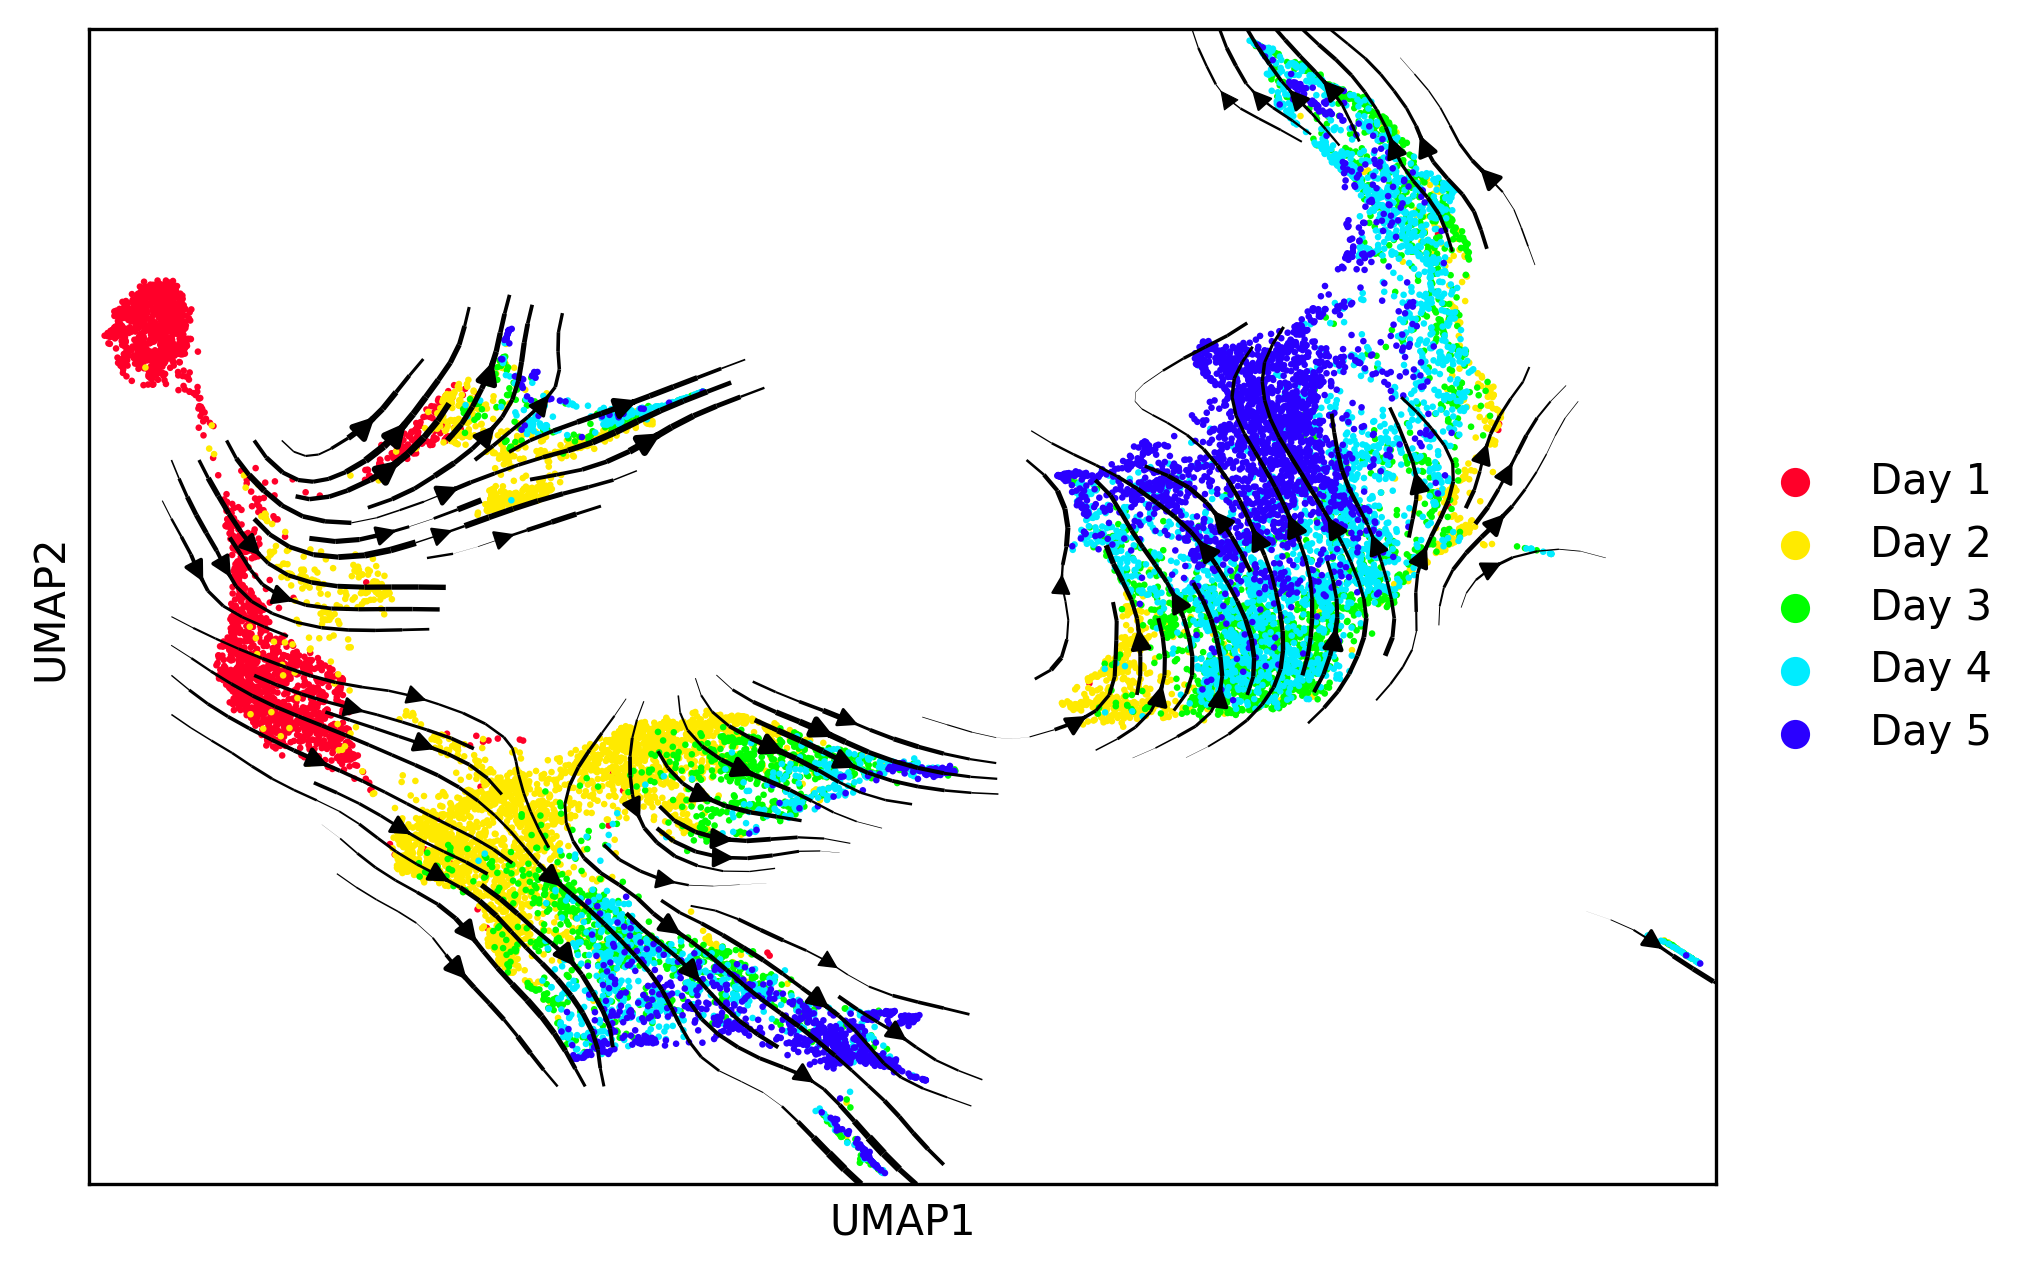

In [56]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
ax = plot_vector_field(adata, E_key='umap', zs_key='cellvec', vf_key='velocity', use_rep_neigh='cellvec',
                  ax=axs, color='time', size=10, palette='custom_map2', grid=False, density=0.8)
ax.set_title(None)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


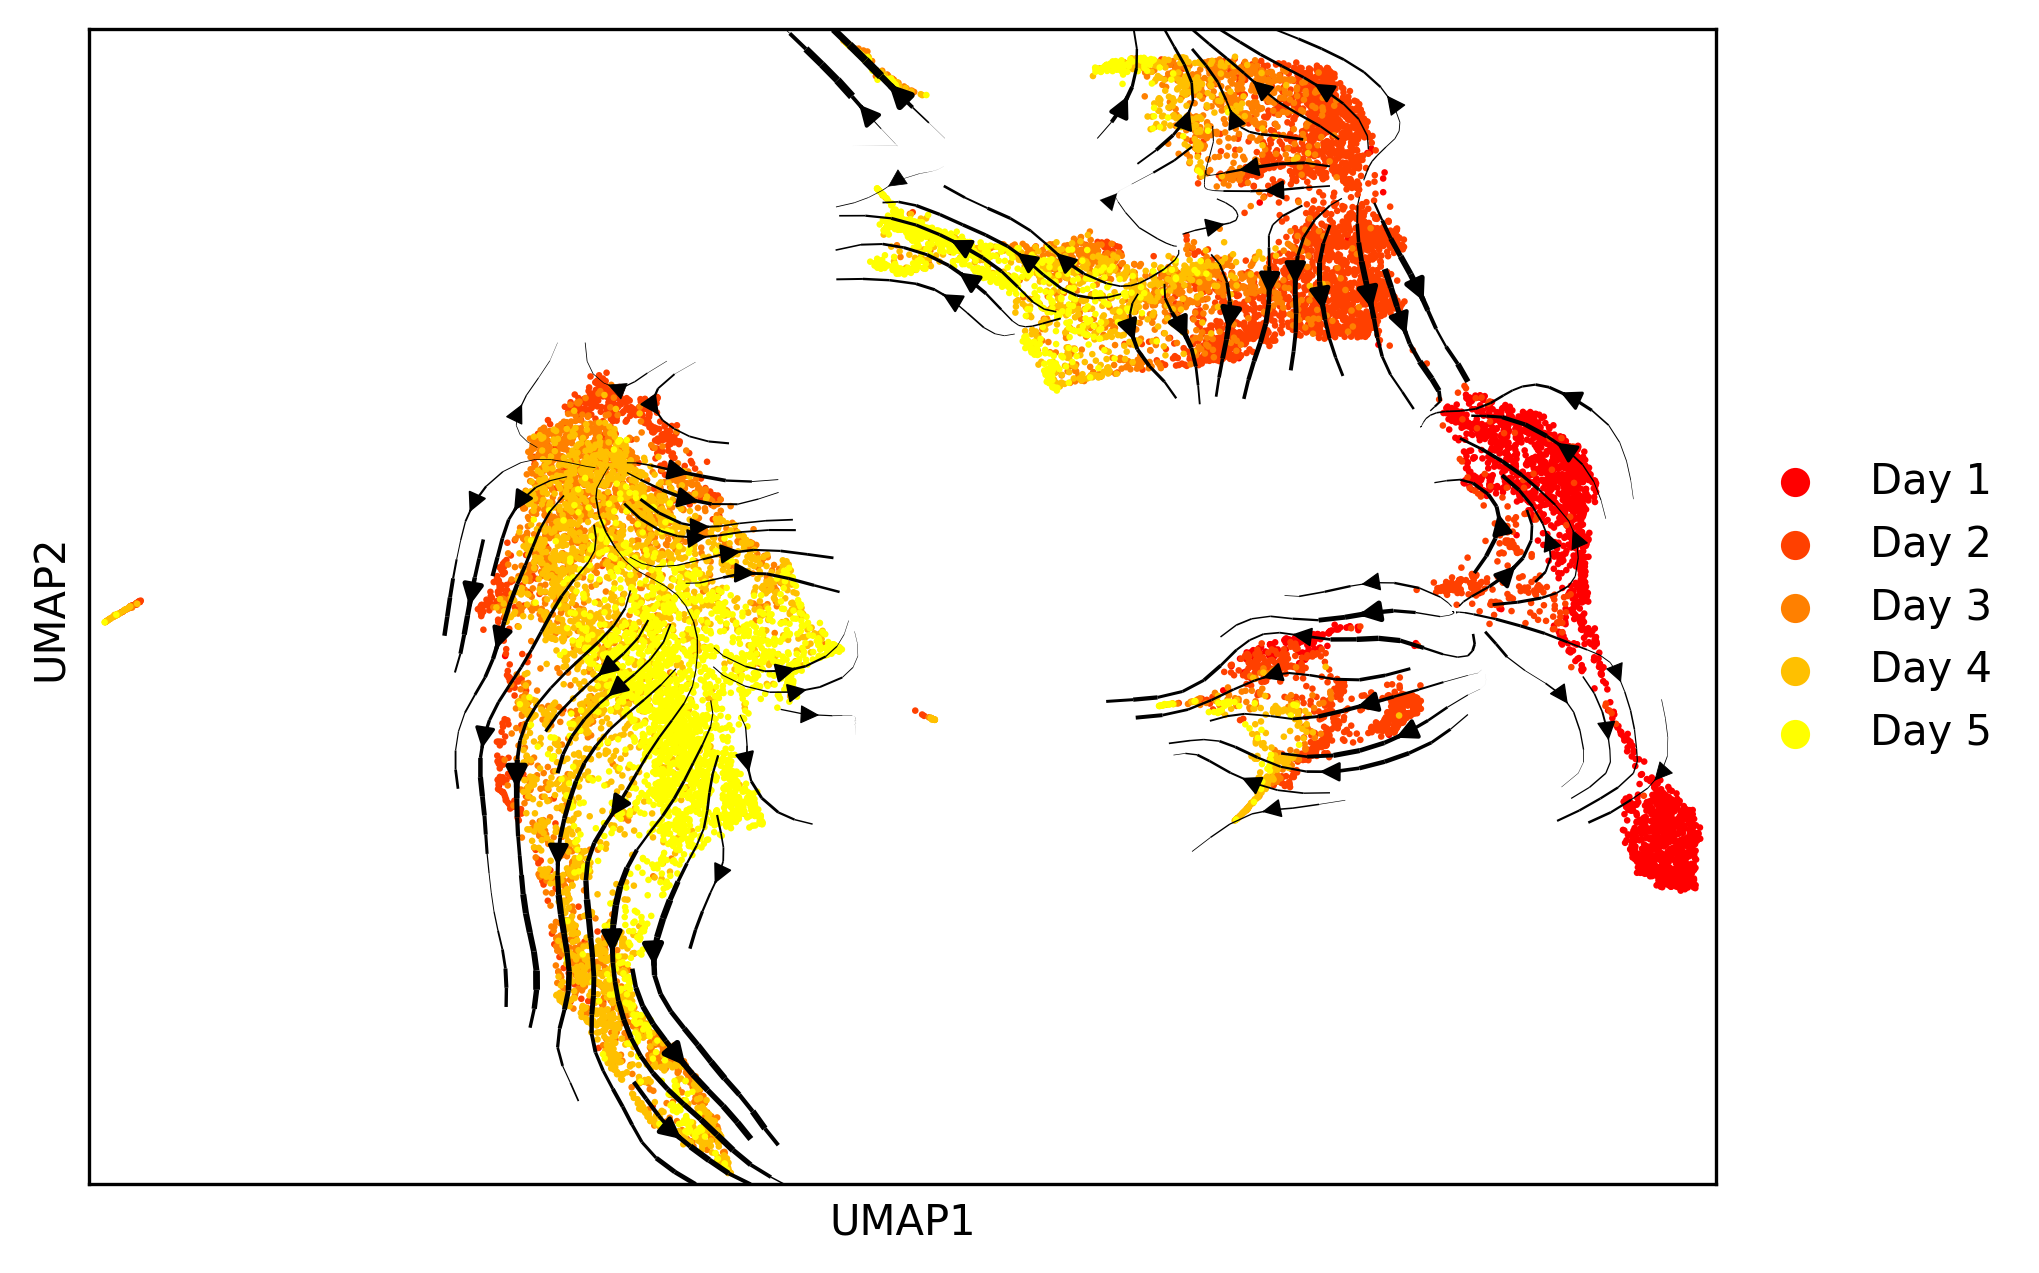

In [78]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
ax = plot_vector_field(adata, E_key='umap', zs_key='cellvec', vf_key='velocity', use_rep_neigh='cellvec',
                  ax=axs, color='time', size=10, palette=plt.cm.autumn.name, grid=False, density=0.8)
ax.set_title(None)
#ax.invert_xaxis()
#ax.invert_yaxis()
plt.show()

In [43]:
velocity=np.tile(2*gene_vec[9132],(n_cell,1))
adata.obsm['X_velocity'] = velocity

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


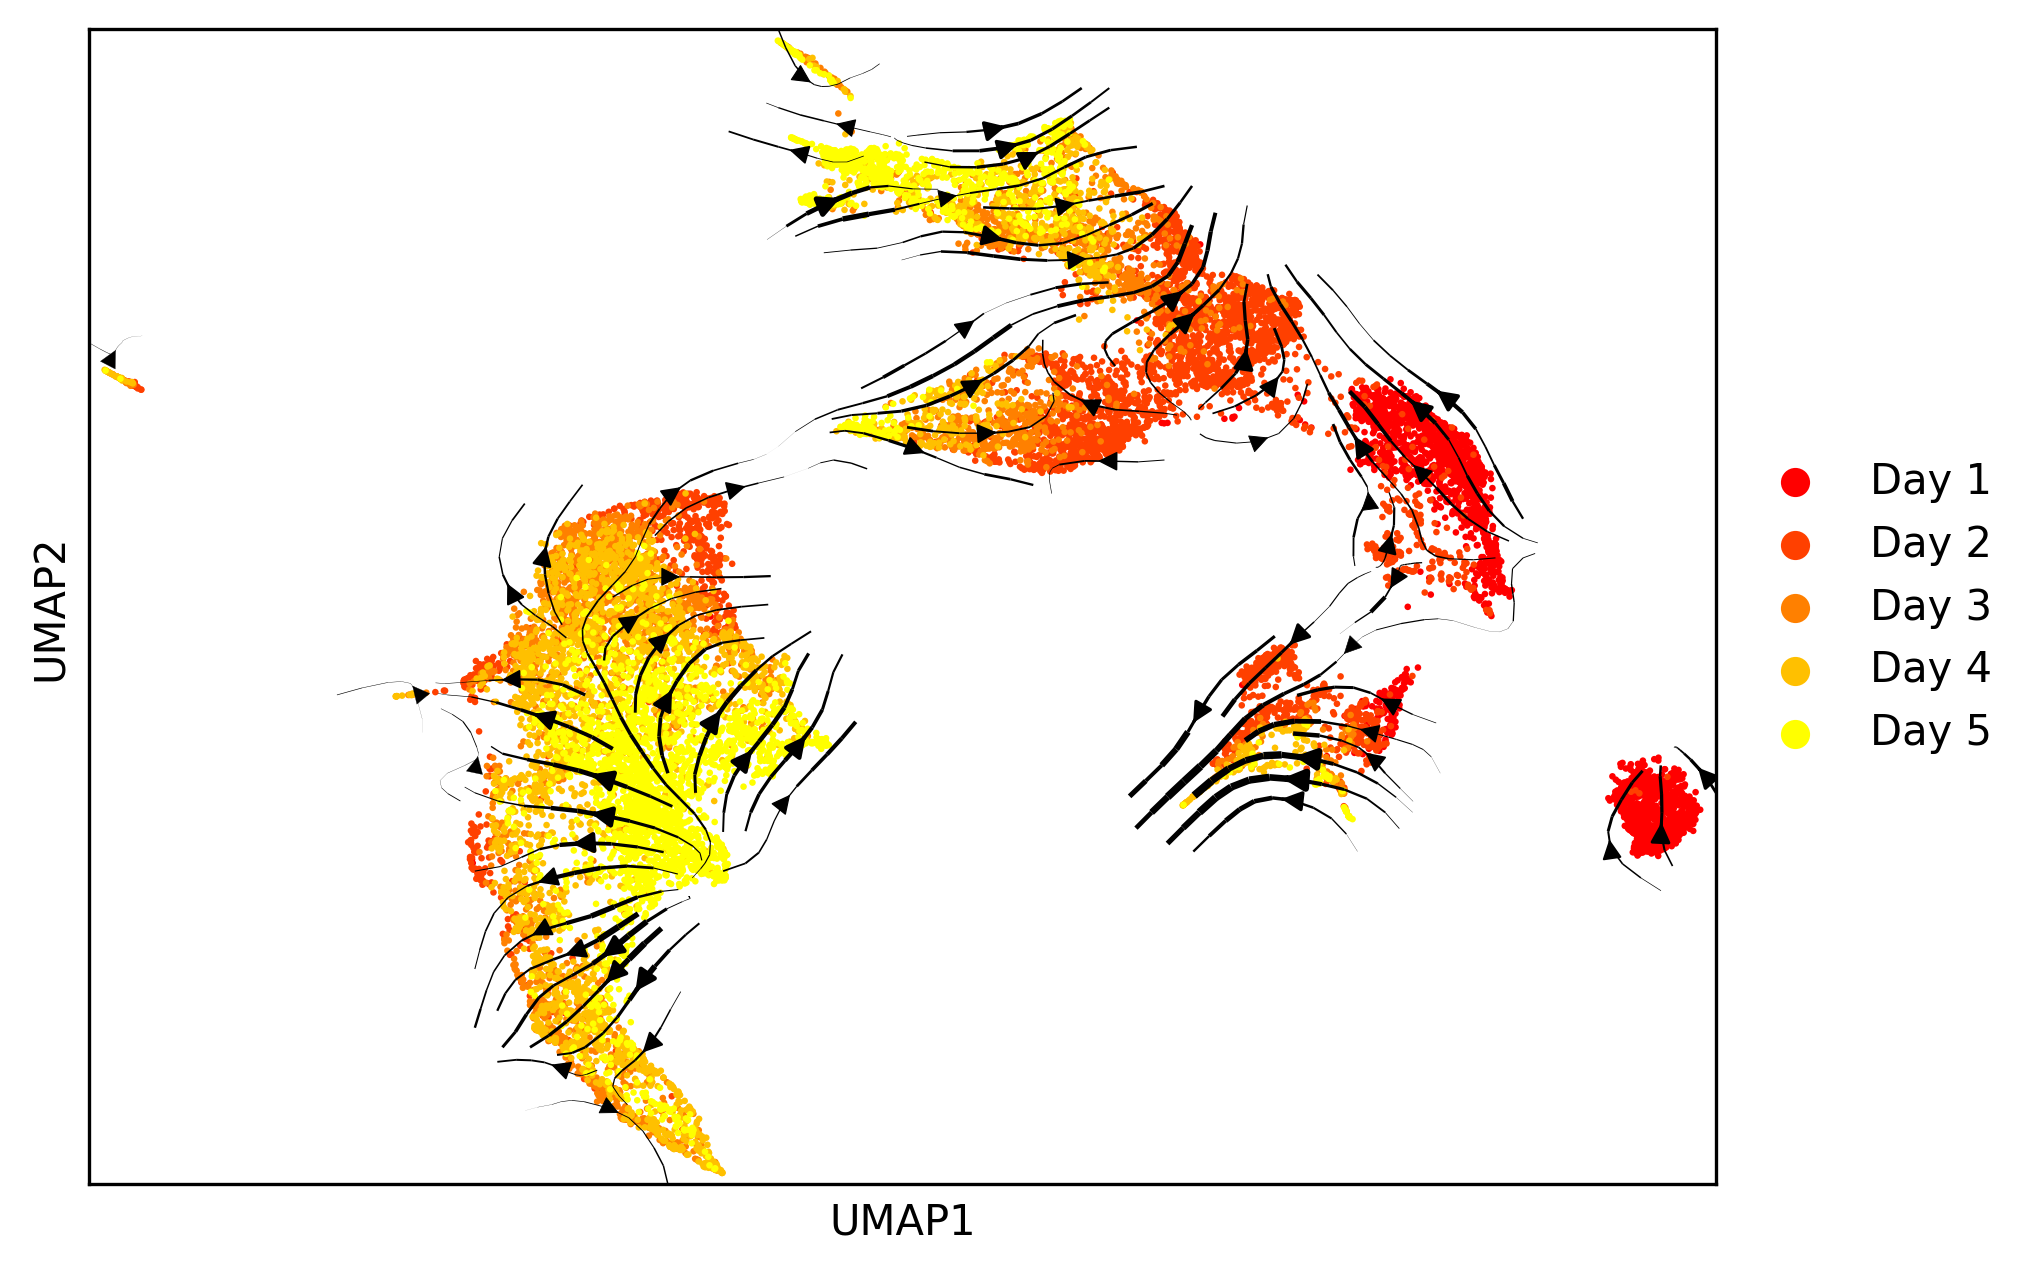

In [44]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
ax = plot_vector_field(adata, E_key='umap', zs_key='cellvec', vf_key='velocity', use_rep_neigh='cellvec',
                  ax=axs, color='time', size=10, palette=plt.cm.autumn.name, grid=False, density=0.8)
ax.set_title(None)
#ax.invert_xaxis()
#ax.invert_yaxis()
plt.show()

D:\anacevm\pytorch\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


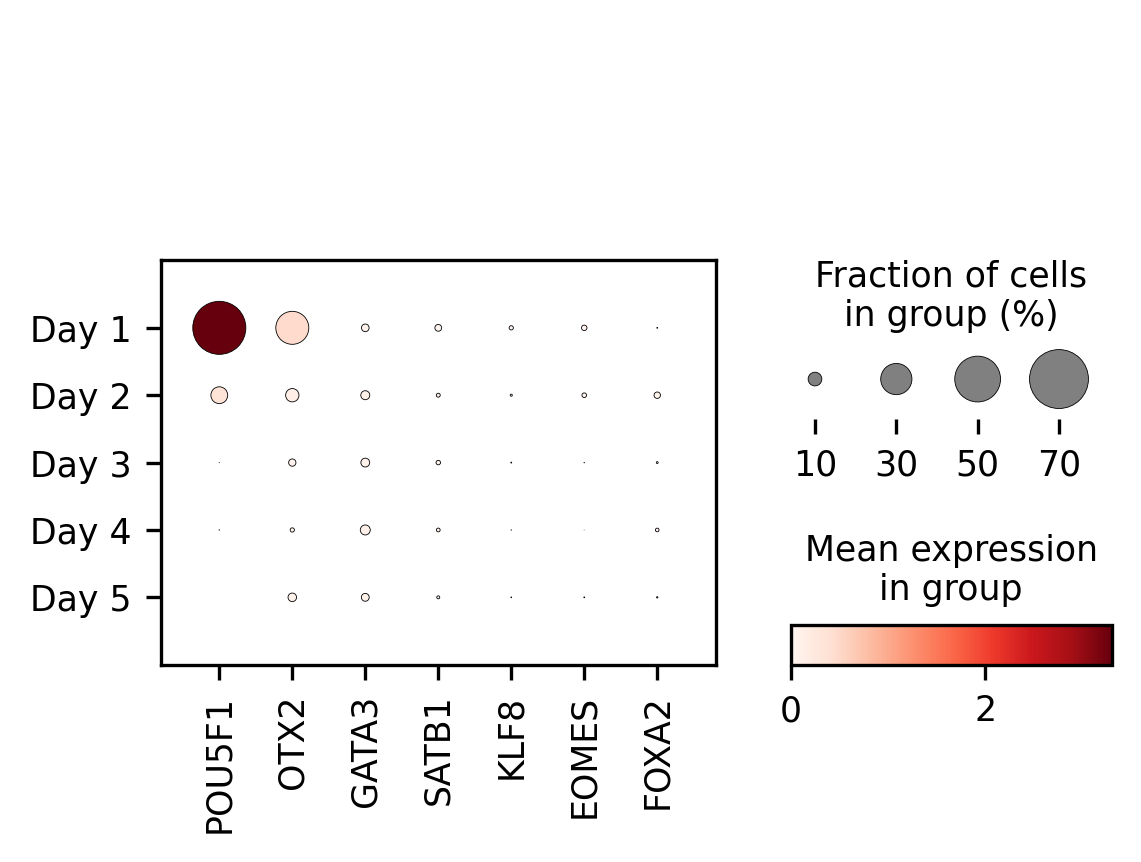

In [61]:
marker_genes = ['POU5F1','OTX2','GATA3','SATB1','KLF8','EOMES','FOXA2']
sc.pl.dotplot(adata, marker_genes, groupby='time');

In [27]:
n_gene

17580

In [29]:
adata.var['gene'][100]

'AC002456.2'

In [40]:
gene_index = adata.var.index.get_loc('A2M-AS1')
    

In [41]:
gene_index

3

In [36]:
gene_index = adata.var.index.get_loc('AC002456.2')

In [37]:
gene_index

100

In [45]:
adata.var['gene'][10]

'AAGAB'

In [85]:
####
gene_index = adata.var.index.get_loc('POU5F1')
gene_index


10748

In [86]:
gene_index = adata.var.index.get_loc('OTX2')
gene_index

9887

In [ ]:
表达GATA3、SATB1和KLF8但不表达Eome或FOXA2

In [83]:
gene_index = adata.var.index.get_loc('GATA3')
gene_index

5621

In [84]:
gene_index = adata.var.index.get_loc('SATB1')
gene_index

13430

In [87]:
gene_index = adata.var.index.get_loc('KLF8')
gene_index

7358

In [90]:
gene_index = adata.var.index.get_loc('EOMES')
gene_index

4641

In [89]:
gene_index = adata.var.index.get_loc('FOXA2')
gene_index

5403